This notebook will be used to document assumptions, steps in analyses, etc

## Table of contents

Last access (y.m.d): 19.07.15  
Last update (y.m.d): 19.07.05

- Characteristic frequency calculation 
- New measures for spatial frequency tuning

### Basic imports

In [154]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.animation as anim
import matplotlib.cm as cm
import seaborn as sns
import itertools
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean
import scipy.stats as scst

import sys # so that we can import model_responses (in different folder)
import model_responses

# %matplotlib inline

# also, fix warnings so they don't repeat
import warnings
warnings.filterwarnings('once')

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

## fixed
conDig = 3; # round contrast to the 3rd digit
# at CNS
basePath = '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/';
# personal mac
# basePath = '/Users/paulgerald/work/sfDiversity/sfDiv-OriModel/sfDiv-python/';

## edit
expDir   = 'V1_orig/';
fullWaveform = 0;
which_cell = 2; # which cell - index will be which_cell - 1
df_dogType = 0; # 0 - not DoG; 1 - Sach; 2 - Tony
df_lossType = 2; # 1 - lsq; 2 - sqrt; 3 - poiss; 4 - sach

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = np.load(dataPath + 'dataList.npy', encoding='latin1').item();
expInd, expType = hf.get_exp_ind(dataPath, dataList['unitName'][which_cell-1])

df_suff = hf.descrMod_name(df_dogType);
dfName = hf.descrFit_name(df_lossType, 'descrFits_190503', modelName=df_suff);

### Characteristic frequency

Here, I'm checking to see if I can compute characteristic frequency for descriptive functions NOT in the difference of gaussian formula. From Enroth-Cugell and Robson ('66):

> $r_c$ is the radius at which the sensitivity of the central summating region falls to 1/e (37 %) of its maximum value 

Thus, we should be able to simply optimize for the frequency (higher than the peak) at which the descriptive tuning curve has a value of 1/e relative to the maximum.

**Conclusion:** We *can't* do this, since the 1/e point for the center mechanism alone is not the same as the 1/e point for the difference of gaussians. This follows from the fact that though the high frequency cutoff is determined entirely by the center mechinism, the exact fall off from the peak is influenced by the strength of the surround mechanism. Thus, the characteristic frequency - as defined in Enroth-Cugell, Robson - can only be computed with a full difference-of-gaussian fit.  

In [11]:
### Load all of the fits
loss_type = 3; # poiss

# "flex" fit
fLname = 'descrFits_190503'
DoGmodel = 0;
modStr  = hf.descrMod_name(DoGmodel)
fLname  = hf.descrFit_name(loss_type, descrBase=fLname, modelName=modStr);
flexFits = hf.np_smart_load(dataPath + fLname)

# sach fit
fLname = 'descrFits'
DoGmodel = 1;
modStr  = hf.descrMod_name(DoGmodel)
fLname  = hf.descrFit_name(loss_type, descrBase=fLname, modelName=modStr);
sachFits = hf.np_smart_load(dataPath + fLname)

First, let's look at the underlying center and surround mechanisms for the DoG fit.

In [12]:
# pick the cell/fits
sfs_plot = np.logspace(-1, 1, 100);
cellInd = 35;
dispInd = 0;
conInd = 0;

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


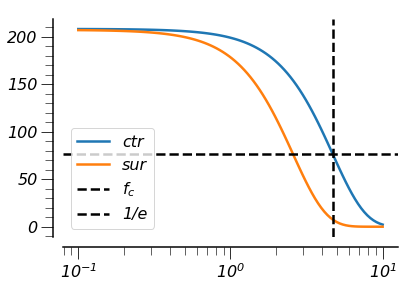

In [13]:
# now, get the fit parameters, and plot the underlying mechanisms
ep = sachFits[cellInd]['params'][dispInd][conInd]
r_c = ep[1];
charFreq = 1/(np.pi*r_c)

gauss = lambda gain_c, r_c, f: gain_c*np.pi*np.square(r_c)*np.exp(-np.square(f*np.pi*r_c))
ctrResps = gauss(ep[0], ep[1], sfs_plot);
plt.semilogx(sfs_plot, ctrResps, label='ctr');
plt.semilogx(sfs_plot, gauss(ep[2], ep[3], sfs_plot), label='sur');
plt.axvline(charFreq, c='k', ls='--', label=r'$f_c$');
plt.axhline(np.max(ctrResps)/np.e, c='k', ls='--', label='1/e')

plt.legend();
sns.despine(offset=10);

Now, let's compare the center 1/e fall off to the fall off of (a similar) full tuning curve.

In [1]:
### Now plot
clrs = ['r', 'k'];
lbls = ['sach', 'flex']
f, ax = plt.subplots(2, 1, figsize=(10, 10))

# first, replicate just the DoG curves
gauss = lambda gain_c, r_c, f: gain_c*np.pi*np.square(r_c)*np.exp(-np.square(f*np.pi*r_c))
ctrResps = gauss(ep[0], ep[1], sfs_plot);
ax[0].semilogx(sfs_plot, ctrResps, label='ctr');
ax[0].semilogx(sfs_plot, gauss(ep[2], ep[3], sfs_plot), label='sur');
ax[0].axvline(charFreq, c='k', ls='--', label=r'$f_c$');
ax[0].axhline(np.max(ctrResps)/np.e, c='k', ls='--', label='1/e')
ax[0].set_title('Center and surround')

ax[0].legend();

## sach
ex_params = sachFits[cellInd]['params'][dispInd][conInd];
resps = hf.get_descrResp(ex_params, sfs_plot, 1);
ax[1].semilogx(sfs_plot, resps, label=lbls[0], c=clrs[0])
r_c = ex_params[1];
charFreq = 1/(np.pi*r_c)
ax[1].plot(charFreq, 0, 'v', c=clrs[0], alpha=0.4, label='ctr 1/e')

## flex
ex_params = flexFits[cellInd]['params'][dispInd][conInd];
resps = hf.get_descrResp(ex_params, sfs_plot, 0);
ax[1].semilogx(sfs_plot, resps, label=lbls[1], c=clrs[1])

#########
### now, compute the char freq - cannot infer from parameters, but 1/e (i.e. ~37%) of max from Enroth-Cugell, Robson ('66))
#########
peak_1e = np.max(resps)/np.e;
obj_fun = lambda sf: np.square(peak_1e-hf.get_descrResp(ex_params, [sf], 0)[0])
bnds = [(ex_params[2], sfs_plot[-1])]
cf = opt.minimize(obj_fun, x0=ex_params[2], bounds=bnds, method='COBYLA')
###
#########

ax[1].plot(cf['x'], 0, 'v', c=clrs[1], alpha=0.4, label='full 1/e')
ax[1].set_title('Comparing full versus center characteristic frequency')

ax[1].legend();
sns.despine(offset=10)

NameError: name 'plt' is not defined

As you can see for this example fit, the characteristic frequency (1/e fall off in the center mechanism; red, from difference of gaussian model parameters) is not the same as the 1/e point of the total tuning curve (black; from optimization). Why? Well, of course the relative strength of the surround mechanism matters! If (and only if) the DoG is just the center, then the 1/e of the center and the full curve are equivalent.

Note: Here, the black curve is the descriptive fit as determined by a "flexible" Gaussian - i.e. a Gaussian where the std to the left and right of the peak are independent. As noted by the similarity of the curves (yes, the peaks are offset, but the low/high frequency fall offs are similar), the discrepancy in the characteristic frequencies is not due to curve differences - rather, it is caused by the inequality between the 1/e point for a full curve versus just an underlying center mechanism, as in a DoG.

### Metrics for spatial frequency tuning

While peak spatial frequency, octave bandwidth, and characteristic frequency (or some other measure of high-frequency fall off) are useful measures, they all require a descriptive tuning curve fit. Ideally, we can develop metrics which capture tuning without any model or inference required. To that end, let's consider how we can determine the central tendency and spread of the tuning curves

#### Center of mass

A common calculation in physics, engineering, etc is the center of mass: $x_{cm} = \frac{\sum_{i} x_i \cdot m_i}{M}, M=\sum_i {m_i}$

Can we consider the same form for center of "mass", i.e. the center of the spatial frequency tuning curve? In that case, we write:

$$ f_{cm} = \frac{ \sum_{i} r_i \cdot f_i}{R}, R=\sum_i {r_i}$$

#### ...and SF variance

What about a measure of the spread or non-uniformity of responses. This should be akin to bandwidth, but again, in a model-free way. We can try:

$$ var_{f} = \frac{ \sum_i r_i \cdot \lvert f_i - f_{cm} \rvert}{R} $$

In [79]:
##########
# Load descriptive fits for comparison
##########

dfits = hf.np_smart_load(dataPath + dfName);

In [211]:
##########
# compute center of mass, variance
##########

CoM = lambda resp, sf: np.dot(np.log2(sf), np.array(resp))/np.sum(resp)

sfVar = lambda cm, resp, sf: np.dot(resp, np.abs(np.log2(sf)-np.log2(cm)))/np.sum(resp)

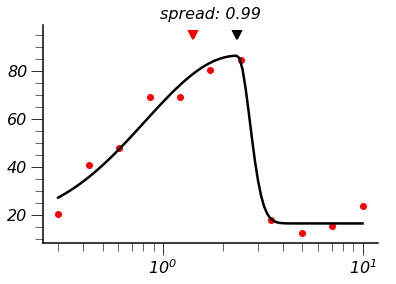

In [207]:
# now, plot an example curve
### For example: 40 (narrow), 1(broad/lowpass), 18 (bandpass)
disp, con = 0, 0;
exInd = 25;

########
# load/organize data
########
exName = dataList['unitName'][exInd];
exCell = hf.np_smart_load(dataPath + exName + '_sfm.npy')
exTr = exCell['sfm']['exp']['trial'];
expInd = hf.get_exp_ind(dataPath, exName)[0];
spks = hf.get_spikes(exTr, expInd=expInd)

sfTuning = hf.organize_resp(spks, exTr, expInd=expInd)[2];
valConds = hf.tabulate_responses(exTr, expInd=expInd)[1];
sfs = valConds[2];

#########
# plot data
#########
resps = sfTuning[disp, :, con];
plt.semilogx(sfs, resps, 'ro');

#########
# plot descriptive fit
#########
curr_df = dfits[exInd]
prms = curr_df['params'][disp][con]
plot_sfs = np.geomspace(sfs[0], sfs[-1], 100);
plot_resp = hf.get_descrResp(prms, plot_sfs, DoGmodel=df_dogType);
plt.semilogx(plot_sfs, plot_resp, c='k');

#########
# compute/plot metrics
#########
peakSf = curr_df['prefSf'][disp][con];
maxResp = np.max(plot_resp)
plt.semilogx(peakSf, 1.1*maxResp, 'v', markersize=8, color='k');

ctr = np.power(2, CoM(resps, sfs));
plt.semilogx(ctr, 1.1*maxResp, 'v', markersize=8, color='r');

sprd = sfVar(ctr, resps, sfs)
plt.title('spread: %.2f' % sprd);

Now, let's ask: how correlated are the model-free and derived measures?

In [212]:
### Gather
nCells = len(dataList['unitName']);
pks = np.nan * np.zeros((nCells, 2))
var = np.nan * np.zeros((nCells, 2))

for i in range(nCells):
    
    exName = dataList['unitName'][i];
    exCell = hf.np_smart_load(dataPath + exName + '_sfm.npy')
    exTr = exCell['sfm']['exp']['trial'];
    expInd = hf.get_exp_ind(dataPath, exName)[0];
    spks = hf.get_spikes(exTr, expInd=expInd)

    sfTuning = hf.organize_resp(spks, exTr, expInd=expInd)[2];
    valConds = hf.tabulate_responses(exTr, expInd=expInd)[1];

    sfs = valConds[2];
    resps = sfTuning[disp, :, con];

    curr_df = dfits[i]
    peakSf = curr_df['prefSf'][disp][con];
    curr_prms = curr_df['params'][disp][con];
    sfBw = hf.compute_SF_BW(curr_prms, height=0.75, sf_range=[0.01, 10])[1];
    
    ctr = np.power(2, CoM(resps, sfs));
    sprd = sfVar(ctr, resps, sfs);

    # now organize
    pks[i, :] = [peakSf, ctr];
    var[i, :] = [sfBw, sprd];

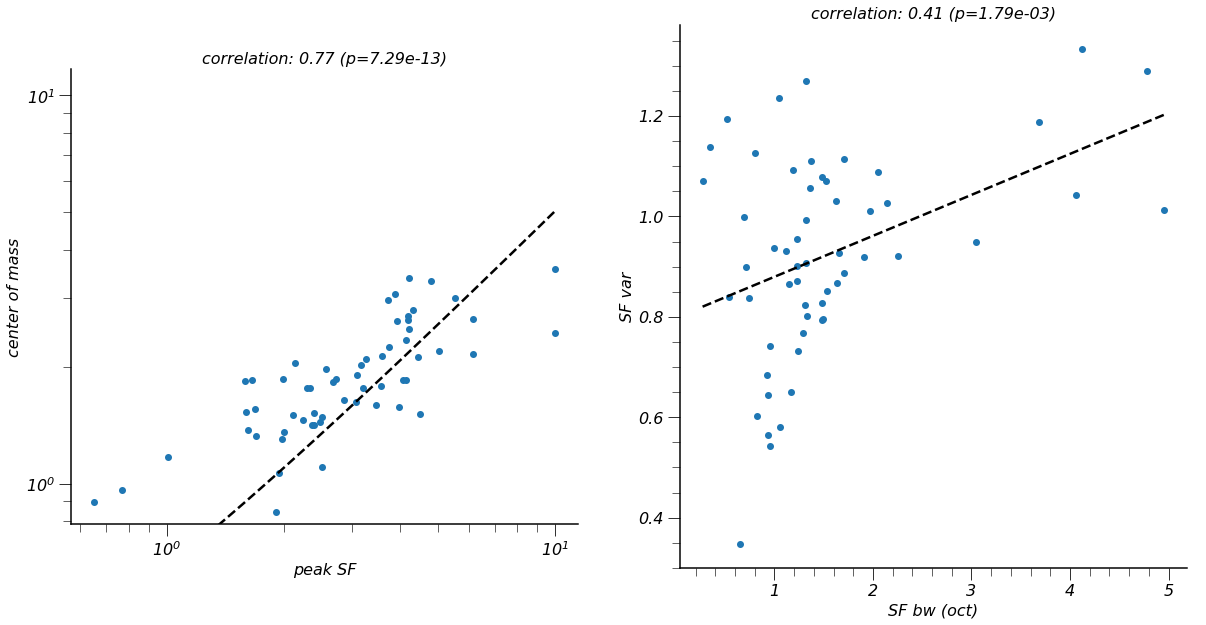

In [213]:
### plot
nPlt = 2;
f, ax = plt.subplots(1, nPlt, figsize=(10*nPlt, 10))

# first, peak/center
ax[0].loglog(pks[:, 0], pks[:, 1], 'o');
ax[0].axis('equal')
ax[0].axis('square')
ax[0].set_xlabel('peak SF');
ax[0].set_ylabel('center of mass');
reg = scst.linregress(np.log2(pks[:, 0]), np.log2(pks[:, 1]))
plot_reg = lambda x, b, sf: b + sf*x;
sfs_plot = np.geomspace(np.min(pks[:, 0]), np.max(pks[:, 0]), 100)
ax[0].loglog(sfs_plot, plot_reg(reg.slope, reg.intercept, sfs_plot), 'k--')
ax[0].set_title('correlation: %.2f (p=%.2e)' % (reg.rvalue, reg.pvalue))

# then, bandwidth/spread
ax[1].plot(var[:, 0], var[:, 1], 'o');
ax[1].set_xlabel('SF bw (oct)');
ax[1].set_ylabel('SF var');
non_nan = ~np.logical_or(np.isnan(var[:,0]), np.isnan(var[:, 1]))
reg = scst.linregress(var[non_nan, 0], var[non_nan, 1])
plot_reg = lambda x, b, bw: b + bw*x;
x_plots = np.linspace(np.nanmin(var[:,0]), np.nanmax(var[:,0]))
ax[1].plot(x_plots, plot_reg(reg.slope, reg.intercept, x_plots), 'k--');
ax[1].set_title('correlation: %.2f (p=%.2e)' % (reg.rvalue, reg.pvalue));



So, what do we make of all this?

TODO:
- Try to "index" the SF var metric, i.e. bounded [0, 1].  
- Should we take into account the SD of a particular response? (i.e. higher varaince SF conditions count less towards the calculation)
